In [30]:
pip install -U torchmetrics

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

In [32]:
def doubleConv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),  # <-- added padding
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),  # <-- added padding
        nn.ReLU(inplace=True)
    )
    return conv

In [33]:
# Making original tensor the same size as target by cropping
def cropImg(encoder_tensor, decoder_tensor):
    _, _, h, w = encoder_tensor.shape
    _, _, target_h, target_w = decoder_tensor.shape

    delta_h = h - target_h
    delta_w = w - target_w

    top = delta_h // 2
    left = delta_w // 2

    return encoder_tensor[:, :, top:top+target_h, left:left+target_w]

In [34]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.maxPool2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.downConv1 = doubleConv(3, 64)
    self.downConv2 = doubleConv(64, 128)
    self.downConv3 = doubleConv(128, 256)
    self.downConv4 = doubleConv(256, 512)
    self.downConv5 = doubleConv(512, 1024)


    self.upTrans1 = nn.ConvTranspose2d(in_channels=1024,
                                       out_channels=512,
                                       kernel_size=2,
                                       stride=2)
    self.upConv1 = doubleConv(1024, 512)

    self.upTrans2 = nn.ConvTranspose2d(in_channels=512,
                                       out_channels=256,
                                       kernel_size=2,
                                       stride=2)
    self.upConv2 = doubleConv(512, 256)

    self.upTrans3 = nn.ConvTranspose2d(in_channels=256,
                                       out_channels=128,
                                       kernel_size=2,
                                       stride=2)
    self.upConv3 = doubleConv(256, 128)

    self.upTrans4 = nn.ConvTranspose2d(in_channels=128,
                                       out_channels=64,
                                       kernel_size=2,
                                       stride=2)
    self.upConv4 = doubleConv(128, 64)

    self.out = nn.Conv2d(in_channels=64,
                         out_channels=1,
                         kernel_size=1)


  def forward(self, image):
    # encoder part
    x1 = self.downConv1(image) #
    x2 = self.maxPool2x2(x1)
    x3 = self.downConv2(x2) #
    x4 = self.maxPool2x2(x3)
    x5 = self.downConv3(x4) #
    x6 = self.maxPool2x2(x5)
    x7 = self.downConv4(x6) #
    x8 = self.maxPool2x2(x7)
    x9 = self.downConv5(x8)

    #decoder part
    x = self.upTrans1(x9)
    y = cropImg(x7, x)
    x = self.upConv1(torch.cat([x, y], 1))

    x = self.upTrans2(x)
    y = cropImg(x5, x)
    x = self.upConv2(torch.cat([x, y], 1))

    x = self.upTrans3(x)
    y = cropImg(x3, x)
    x = self.upConv3(torch.cat([x, y], 1))

    x = self.upTrans4(x)
    y = cropImg(x1, x)
    x = self.upConv4(torch.cat([x, y], 1))

    x = self.out(x)
    print(x.size())
    return x

In [35]:
image = torch.rand((1, 3, 572, 572))
model = UNet()
print(model(image))

torch.Size([1, 1, 560, 560])
tensor([[[[-0.1085, -0.1077, -0.1089,  ..., -0.1078, -0.1090, -0.1076],
          [-0.1031, -0.1044, -0.1052,  ..., -0.1082, -0.1035, -0.1058],
          [-0.1000, -0.0983, -0.1012,  ..., -0.1004, -0.1057, -0.1022],
          ...,
          [-0.1033, -0.1025, -0.0995,  ..., -0.1024, -0.1063, -0.1032],
          [-0.1010, -0.0962, -0.1027,  ..., -0.0980, -0.1048, -0.1048],
          [-0.0989, -0.0951, -0.0945,  ..., -0.0964, -0.1011, -0.0988]]]],
       grad_fn=<ConvolutionBackward0>)


# **Implementing the Model**

In [47]:
#Loading the data from google drive
from google.colab import drive
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score
from torch.utils.data import DataLoader

drive.mount('/content/drive')
basePath = '/content/drive/MyDrive/UNetProject/'
image_dir = basePath + "Training/ISIC2018_Task1-2_Training_Input"
mask_dir = basePath + "Training/ISIC2018_Task1_Training_GroundTruth"
val_image_dir = "/content/drive/MyDrive/UNetProject/Validation/ISIC2018_Task1-2_Validation_Input"
val_mask_dir = "/content/drive/MyDrive/UNetProject/Validation/ISIC2018_Task1_Validation_GroundTruth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
class ISICDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.image_names = sorted([
    f for f in os.listdir(image_dir)
    if f.endswith('.jpg') or f.endswith('.png')])


  def __len__(self):
    return len(self.image_names)

  def __getitem__(self, idx):
    img_name = self.image_names[idx]
    img_path = os.path.join(self.image_dir, img_name)
    mask_name = img_name.replace('.jpg', '_segmentation.png')
    mask_path = os.path.join(self.mask_dir, mask_name)

    # Skip if mask file doesn't exist
    if not os.path.exists(mask_path):
        return self.__getitem__((idx + 1) % len(self.image_names))

    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    image = np.array(image)
    mask = np.array(mask)
    mask = (mask > 0).astype(np.float32)

    if self.transform:
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']

    return image, mask

In [49]:
transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

train_dataset = ISICDataset(image_dir, mask_dir, transform=transform)
val_dataset = ISICDataset(val_image_dir, val_mask_dir, transform=transform)

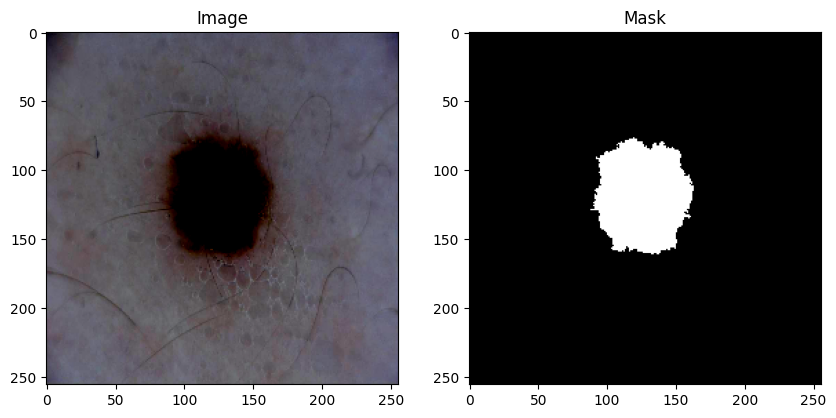

In [50]:
# Testing if it works (DELETE THIS)
# Load one image and mask from the dataset
img, mask = train_dataset[1]

# Convert image to [H, W, C] format and mask to [H, W]
img_np = img.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()

# Plot side-by-side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Mask")
plt.show()

# TRAINING & EVALUATION LOOP

In [51]:
load_trained_model = True  # toggle this if you want to skip training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if load_trained_model:
    model = UNet()
    model.load_state_dict(torch.load("/content/drive/MyDrive/UNetProject/trainedModel.pth"))
    model.to(device)
    model.eval()
else:
    model = UNet().to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # insert training loop here

In [52]:
if not load_trained_model:
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

  num_epochs = 5  # Start small — you can increase later

  for epoch in range(num_epochs):
      model.train()  # Puts model in training mode
      running_loss = 0.0

      for images, masks in train_loader:
          # Send data to GPU
          images = images.to(device)
          masks = masks.to(device).unsqueeze(1)  # Add channel dim if needed

          # Forward pass — model makes predictions
          outputs = model(images)

          # Compute loss (how wrong the predictions are)
          loss = criterion(outputs, masks)

          # Backpropagation + optimization
          optimizer.zero_grad()  # Clear previous gradients
          loss.backward()        # Compute new gradients
          optimizer.step()       # Update model weights

          running_loss += loss.item()

      avg_loss = running_loss / len(train_loader)
      print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")


In [53]:
save_path = "/content/drive/MyDrive/UNetProject/trainedModel.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/UNetProject/trainedModel.pth


torch.Size([1, 1, 256, 256])


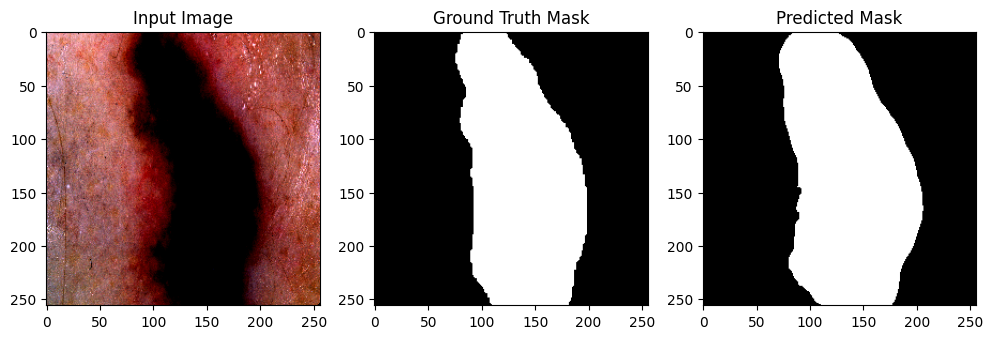

In [54]:
# Grab a single image/mask from validation set
val_img, val_mask = val_dataset[10]  # change the index to see different images
# Move to device and add batch dimension
val_input = val_img.unsqueeze(0).to(device)
with torch.no_grad():
    pred_mask = model(val_input)
    pred_mask = torch.sigmoid(pred_mask)  # apply sigmoid to get values in [0, 1]
    pred_mask = (pred_mask > 0.5).float()  # convert to binary mask
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(val_img.permute(1, 2, 0).cpu())
plt.title("Input Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(val_mask.squeeze().cpu(), cmap="gray")
plt.title("Ground Truth Mask")

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze().cpu(), cmap="gray")
plt.title("Predicted Mask")

plt.show()

In [56]:
# Initialize metrics
dice = BinaryF1Score().to(device)
iou = BinaryJaccardIndex().to(device)

model.eval()
total_dice = 0.0
total_iou = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device).unsqueeze(1)

        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        preds = preds.squeeze(1)
        masks = masks.squeeze(1)

        total_dice += dice(preds, masks)
        total_iou += iou(preds, masks)
        num_batches += 1

# Final averaged scores
avg_dice = total_dice / num_batches
avg_iou = total_iou / num_batches

print(f"Average Dice Score: {avg_dice:.4f}")
print(f"Average IoU Score: {avg_iou:.4f}")

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
Average Dice Score: 0.8494
Average IoU Score: 0.7480
